Surface enhanced raman spectroscopy (SERS) is a surface sensitive technique that enables study of chemical properties of molecules and even mechanism of chemical reaction in nanoscale environment.<br>
Additional confinement of light can be provided by individual atomic protrusion (also called, adatoms) into the gap, called **picocavity**. The gradient field caused by adatoms and their interaction with the molecules nearby provide **excitation of extra vibrational modes** and further enhancement of Raman scattering intensity, enabling direct detection and study of **single surface-bound molecules**.<br>
However, the SERS spectrum from a picocavity is very unstable (varyies in time), and spectrum shape seems to be very random.<br>
My project aims to statistically analysis the peak heights and positions of the picocavity SERS spectra from the same molecules, and try to find out whether there are any principle spectra through looking at the correlation between the peaks.

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from tqdm import tqdm
from scipy.signal import find_peaks
import pandas as pd
import seaborn as sns

Import of the data

In [2]:
File_Path=r'C:\Users\Yuling\Documents\GitHub\DataAnalysis\data'
os.chdir(File_Path)
file=h5py.File('example_data.h5', 'r')#Load the data file

particles=99 #This is id of the site where the spectra are collected
series=2 #This is related to the laser power used for the measurement
laser_power_series=[5,50,100,150,200] #Unit: uW
#The experiment was designed to take a series of measurments with different laser power at each site (particles)
power=laser_power_series[series] #so for measurements labbelled with series=2, the laser power used is 100 uW
print(power)

100


In [3]:
group=file[f'Particle_{particles}_{series}']
spec=np.asarray(group) #import the spectrum (y axis data)
wav=group.attrs['wavelengths'] #import the wavelength of the spectrum

The actual data collected at each site (particle) and under each laser power (series), is a 200s time-scan spectrum with exposure time of 1s.

In [4]:
print(spec.shape)

(200, 867)


Example of one spectrum:
- for a SERS spectra, each peak correspond to a specific vibration mode of the molecule.
    - Position of the peak: the type of vibration mode
    - Height of the peak: the strength of the vibration mode

Text(0, 0.5, 'counts')

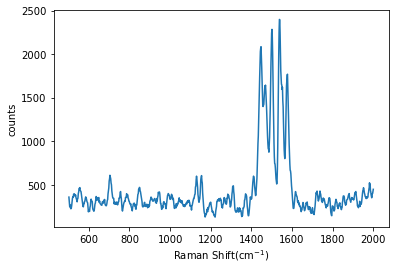

In [5]:
plt.plot(wav,spec[0,:]);plt.xlabel('Raman Shift(cm$^{-1}$)');plt.ylabel('counts')

Example of stacking 200 spectra and plot in contour map:

(200,)


<ipython-input-6-3177cabbec89>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(wav,T,spec);plt.xlabel('Raman Shift(cm$^{-1}$)');plt.ylabel('time(s)');plt.colorbar(label='counts')


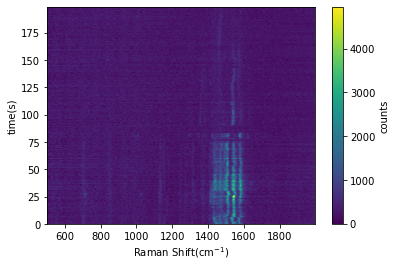

In [6]:
T=np.arange(spec.shape[0]) #time
print(T.shape)
plt.pcolor(wav,T,spec);plt.xlabel('Raman Shift(cm$^{-1}$)');plt.ylabel('time(s)');plt.colorbar(label='counts')

Above is a typical time-scan picocavity SERS spectrum where number of peak, peak position, peak intensity varies in time.
- Note: In the countour map, the counts is represented in colorbar

First, the spectrum is masked by the peak to baseline ratio.
As the 1100-1700 $cm^{-1}$ region is the region of interest and the 1700-1800 $cm^{-1}$ has no raman peaks, the peak/baseline ratio is calculated by:

(maximum counts in  1100-1700 $cm^{-1}$)/(average counts in  1700-1800 $cm^{-1}$)

Note: the pb ratio is calculated along each row in the array

In [7]:
def mask_by_pbratio(spec, x, x_peak=[1400,1700], x_base=[1700,1800]):
    index_p0=np.argmin(abs(x-x_peak[0]))
    index_p1=np.argmin(abs(x-x_peak[1]))
    peak_y=spec[:,index_p1:index_p0]
    peak_x=x[index_p1:index_p0]
    index_b0=np.argmin(abs(x-x_base[0]))
    index_b1=np.argmin(abs(x-x_base[1]))
    base_y=np.average(spec[:,index_b1:index_b0])
    base_x=x[index_b1:index_b0]
    
    pbratio=[x/base_y for x in np.amax(peak_y,axis=1)]
    pbratio=np.around(pbratio,decimals=1)
    pbratio=np.asarray(pbratio)
    return pbratio, peak_y,peak_x, base_y

- pbratio: the peak to baseline ratio
- peak_y: the spectra cutted by the region of interest
- peak_x: the coresponding x axis (1100-1700$cm^{-1}$)
- base_y: the averaged baseline value

In [8]:
r,py,px,by=mask_by_pbratio(spec,wav)
print(spec.shape)
print(wav.shape)
print(py.shape)
print(px.shape)

(200, 867)
(867,)
(200, 181)
(181,)


Text(0, 0.5, 'counts')

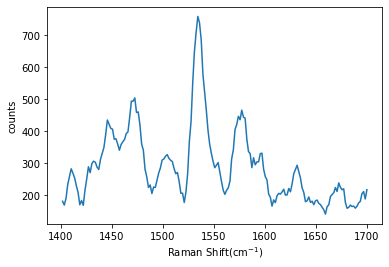

In [9]:
plt.plot(px,py[120,:]);plt.xlabel('Raman Shift(cm$^{-1}$)');plt.ylabel('counts')

<ipython-input-10-b90de5a579e4>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(px,T,py);plt.xlabel('Raman Shift(cm$^{-1}$)');plt.ylabel('time(s)');plt.colorbar(label='counts')


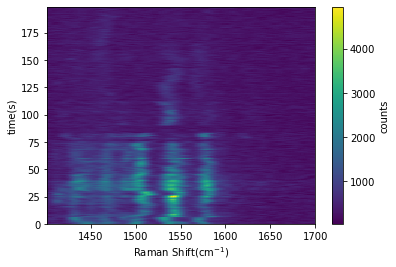

In [10]:
plt.pcolor(px,T,py);plt.xlabel('Raman Shift(cm$^{-1}$)');plt.ylabel('time(s)');plt.colorbar(label='counts')

Then, the data is masked by the pbratio, only the spectrum with pbratio>0 is accepted for future analysis.

In [11]:
mask=np.where(r>3,True,False)
print(mask)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False False  True  True  True  True  True  True
 False False False False False False False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True False False False False False False  True
  True False False  True  True  True  True  True  True False False  True
  True False  True  True  True  True False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [12]:
t_masked=T[mask]
py_masked=py[mask]
print(len(t_masked))
print(py_masked.shape)

118
(118, 181)


- 118 out of 200 spectra pass the threshold.

If a 200s time-scan measurement has more than one spectrum pass the pbratio>3 threshold,
the Raman peaks in the spectrum can be roughly identified using find_peaks function in scipy package.
- Take the first spectrum as a example:

[ 74  90 117 127 141 157]


Text(0, 0.5, 'counts')

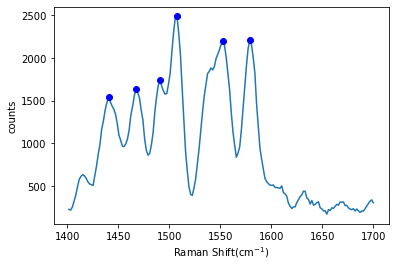

In [13]:
s=py_masked[60,:]
peaks, _ = find_peaks(s, height=by*4,distance=10,prominence=np.std(s)/5)
print(peaks)
plt.plot(px,s);plt.plot(px[peaks],s[peaks],'ob');plt.xlabel('Raman Shift(cm$^{-1}$)');plt.ylabel('counts')

The identified peaks are then labbeled (binning) by its position.<br>
The bin range is already figured out to be [1400,1422,1440,1460,1475,1495,1510,1525,1540,1560,1580,1600,1700].<br>
For example: <br>
- if peak position is 1411, it falls in to the range (1400,1422), so it will be labelled as peak 1.
- if peak position is 1465, it falls in to the range (1460,1475), so it will be labelled as peak 5.

In [14]:
#try to bin the peaks by its position
bins=np.array([1400,1422, 1440, 1460,1475,1495,1510,1525,1540, 1560,1580,1600,1700])
print(bins)
inds = np.digitize(px[peaks], bins)
print(px[peaks])
print(inds)

[1400 1422 1440 1460 1475 1495 1510 1525 1540 1560 1580 1600 1700]
[1578.95951243 1552.4880536  1507.57364447 1490.86113373 1467.39136164
 1440.46792095]
[10  9  6  5  4  3]


In [15]:
def check_duplicate(inds):
    #Check whether multiple peaks fall into the same bin.
    return len(inds)==len(set(inds))

def check_peak_num(index,s,peak_num):
    if len(index)>peak_num:
        i_sorted=sorted(index, reverse=True,key=lambda x: s[x])
        i_cut=i_sorted[:peak_num]
        return i_cut
    else:
        return index
def label_by_pos(x,s,index,bins=[1400,1422,1440, 1460,1475,1495,1510,1525,1540, 1560,1580,1600,1700]):
    peak_num=len(bins)-1
    index=check_peak_num(index,s,peak_num)
    px_labeled=[None]*peak_num
    py_labeled=[None]*peak_num
    bins=np.array(bins)
    inds = np.digitize(x[index], bins)-1 #because the index in a list start from 0
    check=check_duplicate(inds)
    if check==True:
        for i in range(len(index)):
            px_labeled[inds[i]]=round(x[index[i]])
            py_labeled[inds[i]]=round(s[index[i]])
    return check,inds,px_labeled,py_labeled

- Note: If there are multiple peaks fall into same bin, the px_label/py_label will be empty list

Then, I loop through all the spectra pass the pbratio filter, and stored the information interested in the corresponding lists and then stored in a Pandas DataFrame
- The number of peaks identified in a single spectrum is stored in the list **p_num**
- The positions of the peaks are stored in the list **px_all**
- The height (counts) of the peaks are stored in the list **py_all**
- Whether there are multiple peak in one bin **no_dup**
  - False: some of the bin has more than one peak positions stored, peak information of this spectrum will not be stored

In [16]:
if len(py_masked)>0:
    px_all=[]
    py_all=[]
    p_num=[]
    no_dup=[]#no duplicate peaks in one bin
    for i in range(len(py_masked)):
        s=py_masked[i,:]
        peaks, _ = find_peaks(s, height=by*3,distance=10,prominence=np.std(s)/5)
        p_num.append(len(peaks))
        check,inds,px_sorted,py_sorted=label_by_pos(px,s,peaks)
        px_all.append(px_sorted)
        py_all.append(py_sorted)
        if check==False:
            no_dup.append(False)
        if check==True:#no duplicate peaks in one bin
            no_dup.append(True)
    px_all=np.asarray(px_all)
    py_all=np.asarray(py_all)
    data={'NP':[particles]*len(t_masked),
          'time':t_masked,
          'power':[power]*len(t_masked),
          'p_num':p_num,
          'no_dup':no_dup,
          'p1_I':py_all[:,0],
          'p1_x':px_all[:,0],
          'p2_I':py_all[:,1],
          'p2_x':px_all[:,1],
          'p3_I':py_all[:,2],
          'p3_x':px_all[:,2],
          'p4_I':py_all[:,3],
          'p4_x':px_all[:,3],
          'p5_I':py_all[:,4],
          'p5_x':px_all[:,4],
          'p6_I':py_all[:,5],
          'p6_x':px_all[:,5],
          'p7_I':py_all[:,6],
          'p7_x':px_all[:,6],
          'p8_I':py_all[:,7],
          'p8_x':px_all[:,7],
          'p9_I':py_all[:,8],
          'p9_x':px_all[:,8],
          'p10_I':py_all[:,9],
          'p10_x':px_all[:,9],
          'p11_I':py_all[:,10],
          'p11_x':px_all[:,10],
          'p12_I':py_all[:,11],
          'p12_x':px_all[:,11]}
    df=pd.DataFrame(data=data)

In [17]:
df.head()

,NP,time,power,p_num,no_dup,p1_I,p1_x,p2_I,p2_x,p3_I,...,p8_I,p8_x,p9_I,p9_x,p10_I,p10_x,p11_I,p11_x,p12_I,p12_x
0,99,0,100,5,True,None,None,None,None,2086,...,2399,1538,None,None,1771,1577,None,None,None,None
1,99,1,100,5,True,None,None,None,None,1849,...,2344,1539,None,None,1973,1574,None,None,None,None
2,99,2,100,5,True,None,None,1695,1437,None,...,2159,1536,None,None,1962,1571,None,None,None,None
3,99,3,100,5,True,None,None,1688,1434,None,...,2215,1533,None,None,1752,1571,None,None,None,None
4,99,4,100,5,True,None,None,2069,1434,None,...,2696,1533,None,None,2146,1571,None,None,None,None


In [18]:
df['p_num'].value_counts()

5    54
1    36
6    20
4     5
3     2
7     1
Name: p_num, dtype: int64

I loop through all the particles and series, and stored the data in the **peak_info_by_pos.csv** file, and merged with **bkg_info.csv**.
- **bkg_info.csv** contains the background of each spectrum (substracted in the previous processing).


In [19]:
peak=pd.read_csv('peak_info_by_pos.csv')
peak.head()

,NP,time,power,p_num,no_dup,p1_I,p1_x,p2_I,p2_x,p3_I,...,p8_I,p8_x,p9_I,p9_x,p10_I,p10_x,p11_I,p11_x,p12_I,p12_x
0,0,3,5,1,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,11951.0,1543.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,4,5,1,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,12081.0,1546.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,5,5,1,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,13525.0,1548.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,6,5,1,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,11529.0,1549.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,7,5,1,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,12688.0,1548.0,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
bkg=pd.read_csv('bkg_info.csv')
bkg.head()

,NP,power,time,bkg
0,0,5.0,3,0.000000
1,0,5.0,4,0.000000
2,0,5.0,5,0.000000
3,0,5.0,6,0.000000
4,0,5.0,7,203480.663603


In [21]:
data_merge=pd.merge(peak,bkg,how='left',on=['NP','power','time'])
data_merge=data_merge[data_merge['no_dup']]
data_merge=data_merge.drop(columns=['no_dup','NP','time'])
data_merge.head()

,power,p_num,p1_I,p1_x,p2_I,p2_x,p3_I,p3_x,p4_I,p4_x,...,p8_x,p9_I,p9_x,p10_I,p10_x,p11_I,p11_x,p12_I,p12_x,bkg
0,5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11951.0,1543.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12081.0,1546.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2,5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,13525.0,1548.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
3,5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,11529.0,1549.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
4,5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12688.0,1548.0,NaN,NaN,NaN,NaN,NaN,NaN,203480.663603


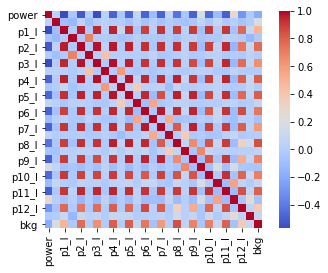

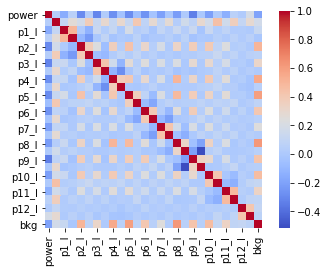

In [22]:
sns.heatmap(data_merge.corr(), cmap='coolwarm', square=True) #value=None if no peaks detected in the bin
plt.show()
data_fill_na = data_merge.fillna(value=0) #value=0 if no peaks detected in the bin
sns.heatmap(data_fill_na.corr(), cmap='coolwarm', square=True)
plt.show()

In [23]:
data_merge['p_num'].value_counts()

4     17390
5     17366
3     12875
1     11525
2     10820
6      9078
7      2097
8       228
9         9
0         4
10        1
Name: p_num, dtype: int64

Then the potential corelations between peaks position and height are investigated using seaborn pariplot.

In [24]:
data_peak_pos=data_merge.loc[:,['power','p1_x','p2_x','p3_x','p4_x','p5_x','p6_x','p7_x','p8_x','p9_x','p10_x','p11_x','p12_x']]
data_peak_pos.head()

,power,p1_x,p2_x,p3_x,p4_x,p5_x,p6_x,p7_x,p8_x,p9_x,p10_x,p11_x,p12_x
0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1543.0,NaN,NaN,NaN
1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1546.0,NaN,NaN,NaN
2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1548.0,NaN,NaN,NaN
3,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1549.0,NaN,NaN,NaN
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1548.0,NaN,NaN,NaN


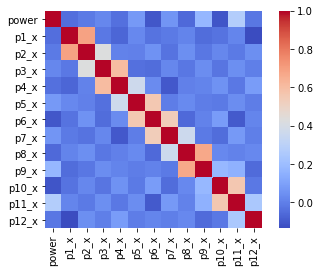

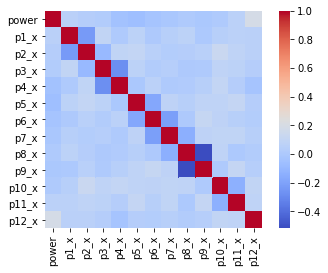

In [33]:
sns.heatmap(data_peak_pos.corr(), cmap='coolwarm', square=True)
plt.show()
peak_pos = data_peak_pos.fillna(value=0)
sns.heatmap(peak_pos.corr(), cmap='coolwarm', square=True)
plt.show()

In [26]:
data_peak_I=data_merge.loc[:,['power','p1_I','p2_I','p3_I','p4_I','p5_I','p6_I','p7_I','p8_I','p9_I','p10_I','p11_I','p12_I']]
peak_I_fill_na = data_peak_I.fillna(value=0)
peak_I_fill_na.head()

,power,p1_I,p2_I,p3_I,p4_I,p5_I,p6_I,p7_I,p8_I,p9_I,p10_I,p11_I,p12_I
0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11951.0,0.0,0.0,0.0
1,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12081.0,0.0,0.0,0.0
2,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13525.0,0.0,0.0,0.0
3,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11529.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12688.0,0.0,0.0,0.0


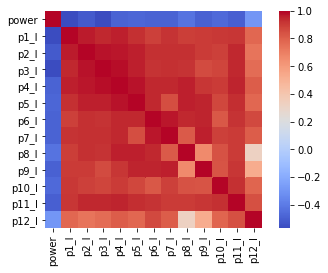

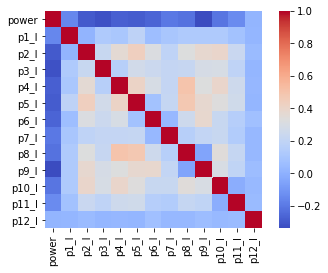

In [27]:

sns.heatmap(data_peak_I.corr(), cmap='coolwarm', square=True)
plt.show()
sns.heatmap(peak_I_fill_na.corr(), cmap='coolwarm', square=True)
plt.show()

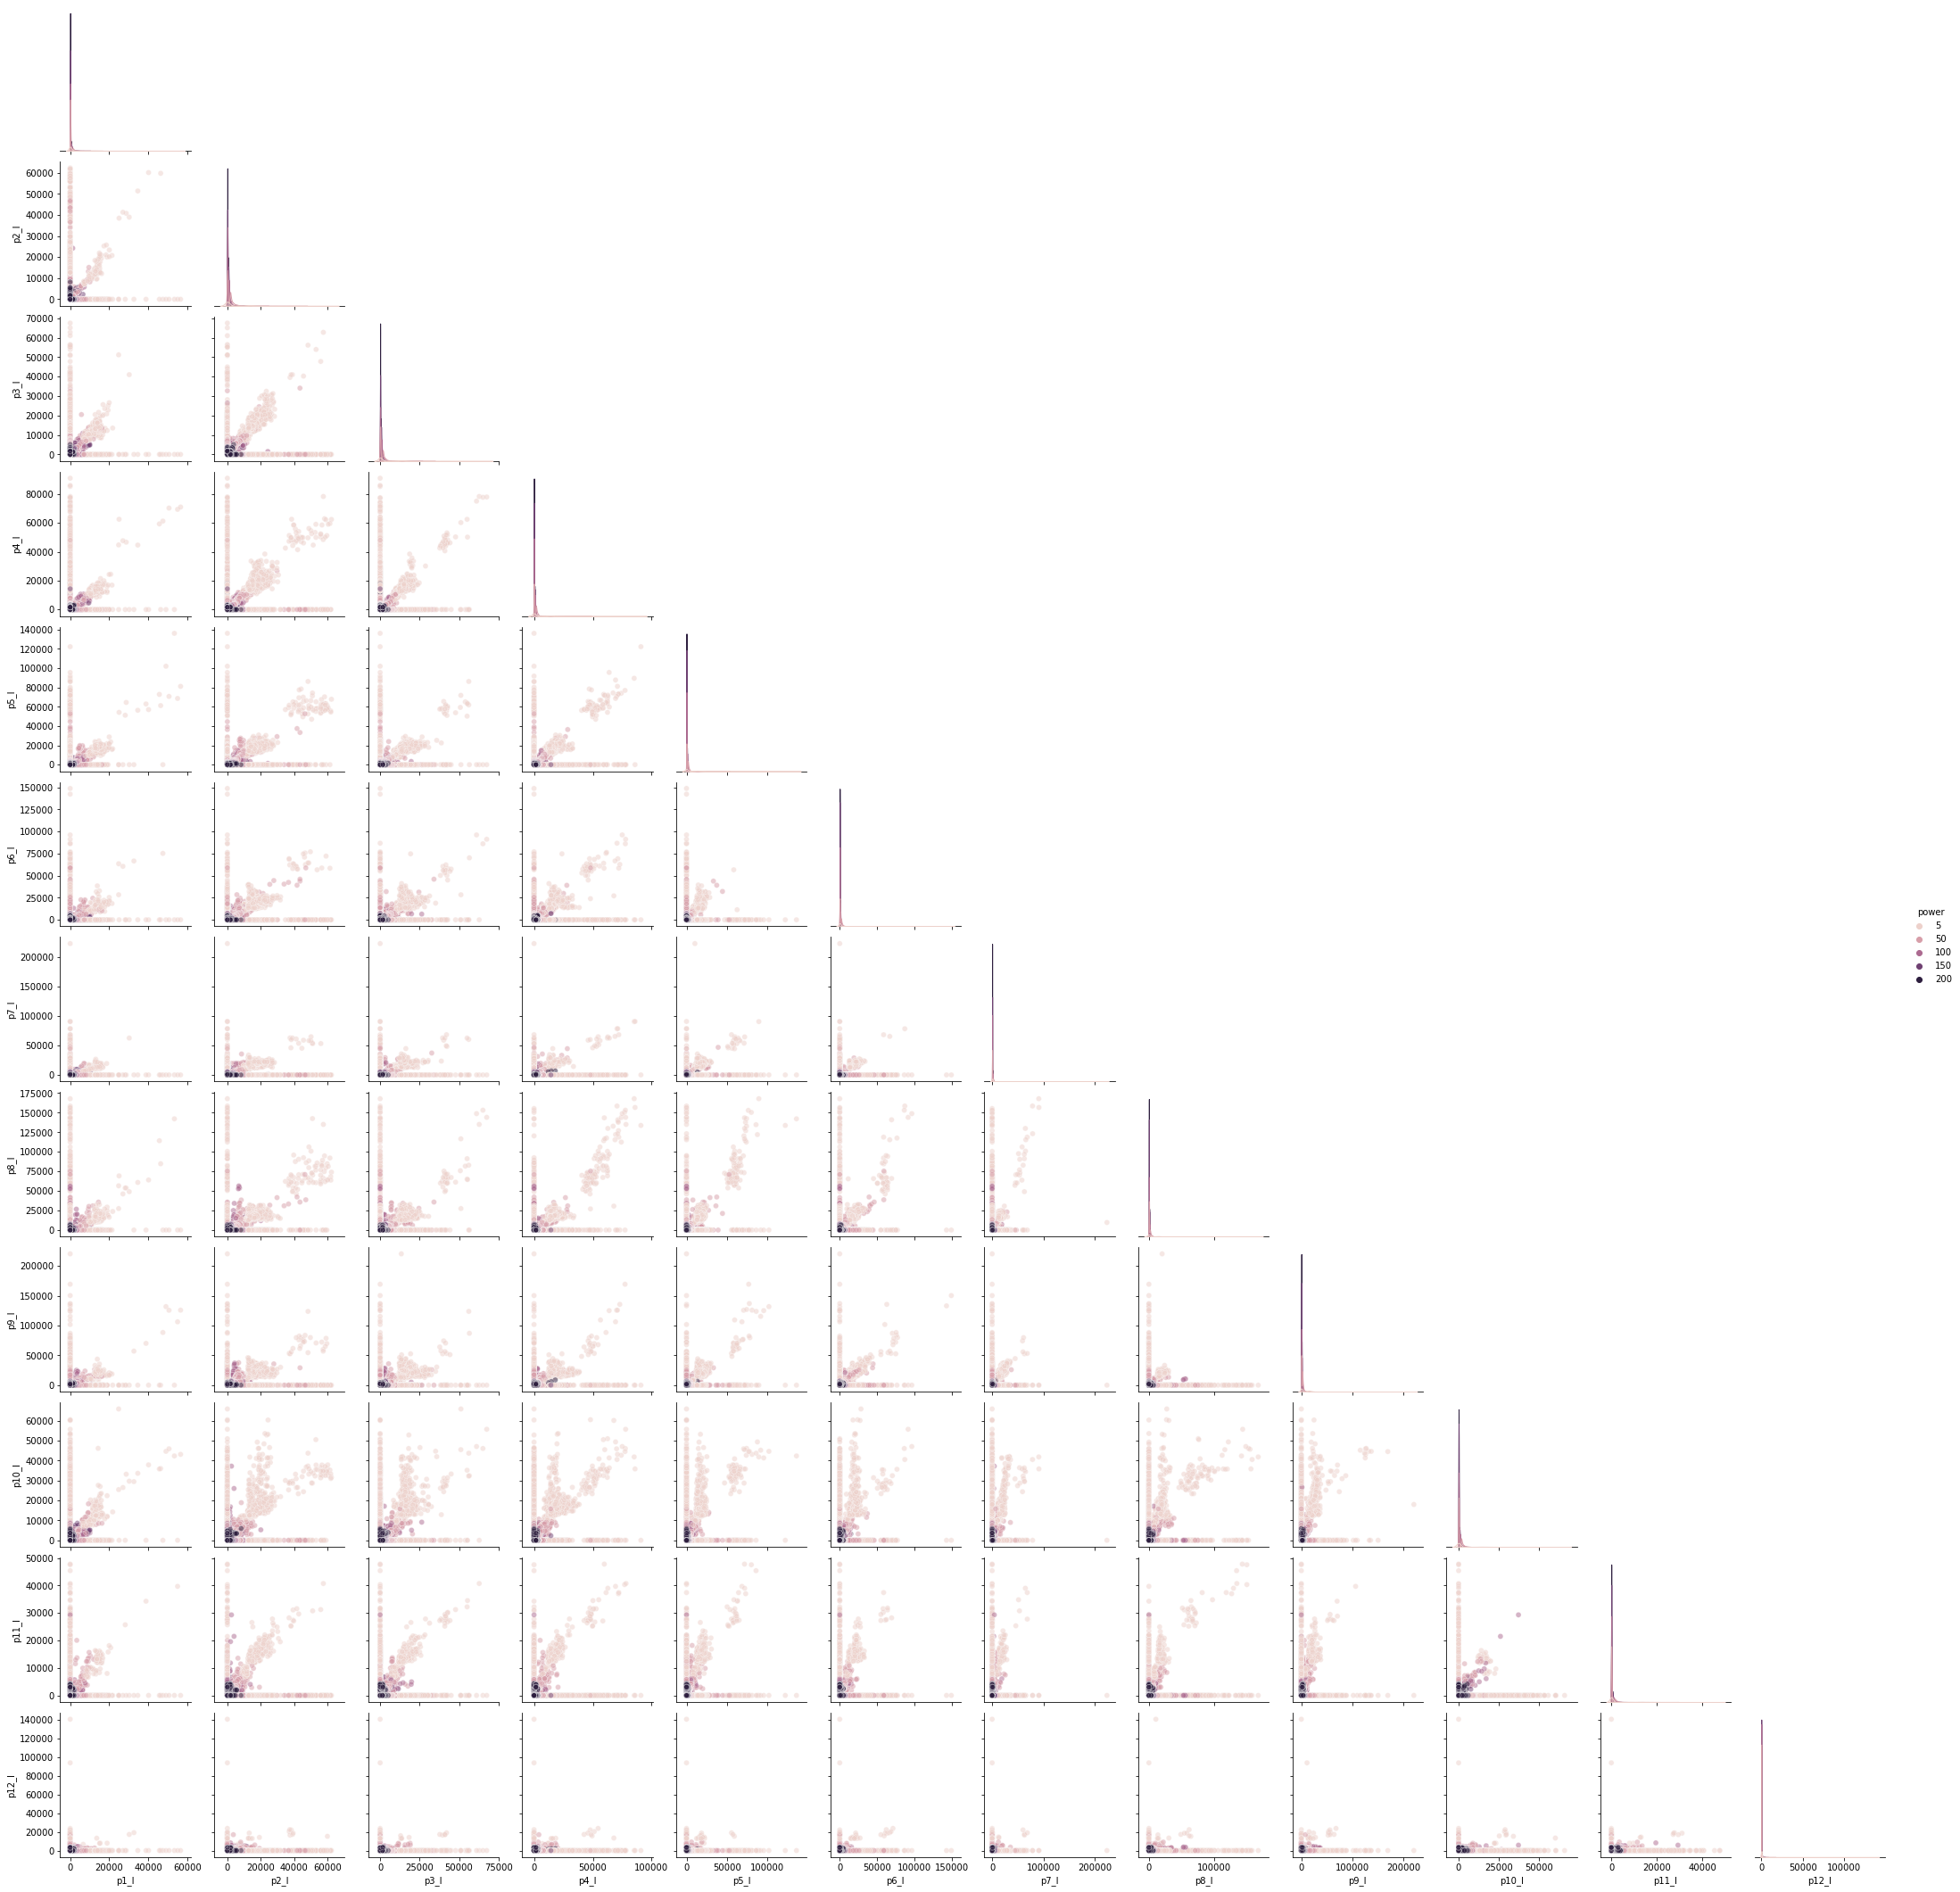

In [28]:
sns.pairplot(peak_I_fill_na,vars=['p1_I','p2_I','p3_I','p4_I','p5_I','p6_I','p7_I','p8_I','p9_I','p10_I','p11_I','p12_I'],hue='power',plot_kws={'alpha':0.5}, corner=True)

In [29]:
from sklearn.decomposition import PCA
X=data_merge
y = X['power']

X = X.fillna(value=0)
X.head()
pca = PCA(n_components=2)
X_r = pca.fit_transform(X)
# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

print(pca.explained_variance_ratio_[0])

explained variance ratio (first two components): [9.99874345e-01 3.13185940e-05]
0.99987434459766


In [30]:
print(y)

0          5
1          5
2          5
3          5
4          5
        ... 
82789    200
82790    200
82791    200
82792    200
82793    200
Name: power, Length: 81393, dtype: int64


In [31]:
pcDf = pd.DataFrame(data = X_r
             , columns = ['pc1', 'pc2'])
finalDf = pd.concat([pcDf, y], axis = 1)

print(finalDf['power'].value_counts())
finalDf.head()

100.0    18993
150.0    18802
50.0     18291
200.0    18104
5.0       7203
Name: power, dtype: int64


,pc1,pc2,power
0,-671458.572481,8492.036595,5.0
1,-671458.277175,8592.446968,5.0
2,-671454.998370,9705.859045,5.0
3,-671459.530404,8167.051505,5.0
4,-467980.222717,8935.548244,5.0


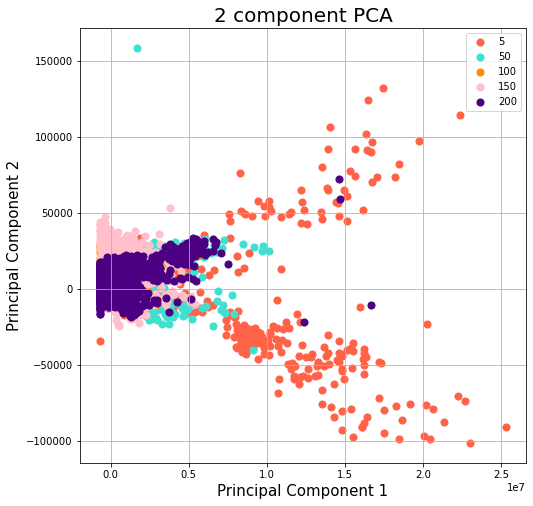

In [32]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [5,50,100, 150, 200]
colors = ["tomato", "turquoise", "darkorange",'pink','indigo']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['power'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1']
               , finalDf.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()